In [9]:
import pandas as pd
import numpy as np
import regex as re
from numpy import nan
import seaborn as sns

## Airbnb predictions competition

In this notebook, it is explained the code to better predict the airbnb prices of Amsterdam city.

The idea behind the competition is to have a set of data of around 4000 airbnb adds(train.csv), and after cleaning and categorizing it, try to predict the prices of around 1300 adds (test.csv). 

In [10]:
#Import data
ab=pd.read_csv('train.csv')

In [11]:
ab.shape

(4167, 74)

/home/lapalmi87/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price', ylabel='room_type'>

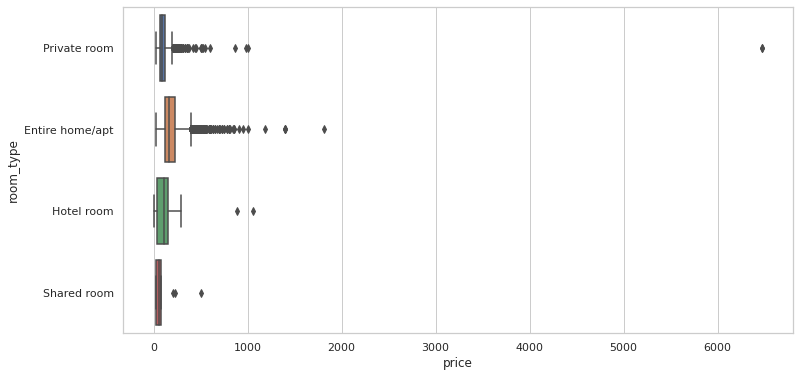

In [12]:
#by a category, we see the outliers from the train file. 
sns.set_context("poster")
sns.set(rc={"figure.figsize": (12.,6.)})
sns.set_style("whitegrid")
sns.boxplot(ab.price,ab.room_type)

In [13]:
#reduce the outliers since there very high prices
Q1 = ab.price.quantile(0.04)
Q3 = ab.price.quantile(0.90)
IQR = Q3 - Q1

ab = ab[~((ab['price'] < (Q1)) |(ab['price']  > (Q3*3)))]

/home/lapalmi87/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price', ylabel='room_type'>

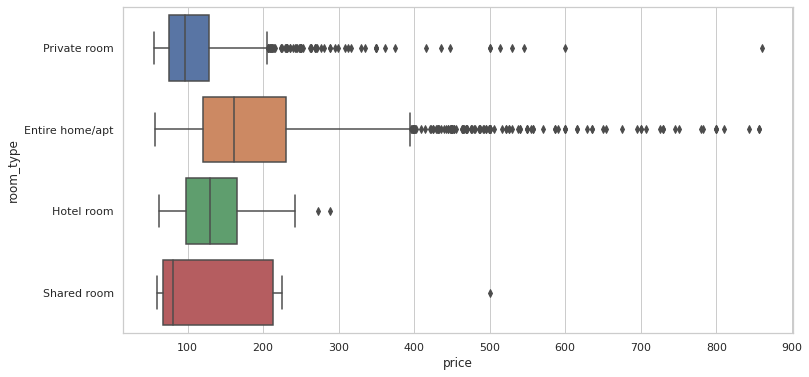

In [14]:
sns.boxplot(ab.price,ab.room_type)

In [15]:
#bring the numeric data
df_numeric=ab._get_numeric_data().drop(columns=['host_id', 'bathrooms', 'calendar_updated',
                                       'review_scores_rating', 'review_scores_cleanliness', 
                                       'review_scores_checkin', 'review_scores_location', 
                                       'calculated_host_listings_count', 
                                       'calculated_host_listings_count_entire_homes', 
                                       'calculated_host_listings_count_private_rooms', 
                                       'calculated_host_listings_count_shared_rooms',
                                       'reviews_per_month','scrape_id', 'neighbourhood_group_cleansed','bedrooms','beds',
                                        'review_scores_accuracy', 'review_scores_communication', 
                                        'review_scores_value','minimum_minimum_nights','maximum_minimum_nights', 
                                        'minimum_maximum_nights', 'maximum_maximum_nights','number_of_reviews_ltm',
                                        'number_of_reviews_l30d', 'availability_60', 
                                        'availability_30', 'availability_365', 
                                        'host_total_listings_count','minimum_nights'])

In [16]:
df_numeric.isna().sum()

id                        0
host_listings_count       0
latitude                  0
longitude                 0
accommodates              0
price                     0
maximum_nights            0
minimum_nights_avg_ntm    0
maximum_nights_avg_ntm    0
availability_90           0
number_of_reviews         0
dtype: int64

In [19]:
#create a function to convert superhost column of 't' and 'f' in 0 and 1. 
def bool_host(x):
    #convierto a los host en true or false (1,0)
    superhost = 0
    if x == 't':
        superhost=1
    else:
        superhost=0
    return superhost

In [18]:
#we add the column bathrooms to the numeric dataframe, 
#considering that there are numbers at the beginning of the string and the ones that not,
#will have a 'half-bath' description.


baths = list(ab.bathrooms_text)
bath = []
half = 'half-bath'
for i in baths:
    try:
        bath.append(float(i.split(' ', 1)[0]))
    except:
        bath.append(0.5)
    
df_numeric['bathrooms'] = bath

In [13]:
#we add the column superhost to the numeric dataframe
df_numeric['superhost']=ab.host_is_superhost.apply(bool_host) #convierto los baños en compartidos.

In [14]:
#having the final following columns
df_numeric.columns

Index(['id', 'host_listings_count', 'latitude', 'longitude', 'accommodates',
       'price', 'maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'availability_90', 'number_of_reviews',
       'bathrooms', 'superhost'],
      dtype='object')

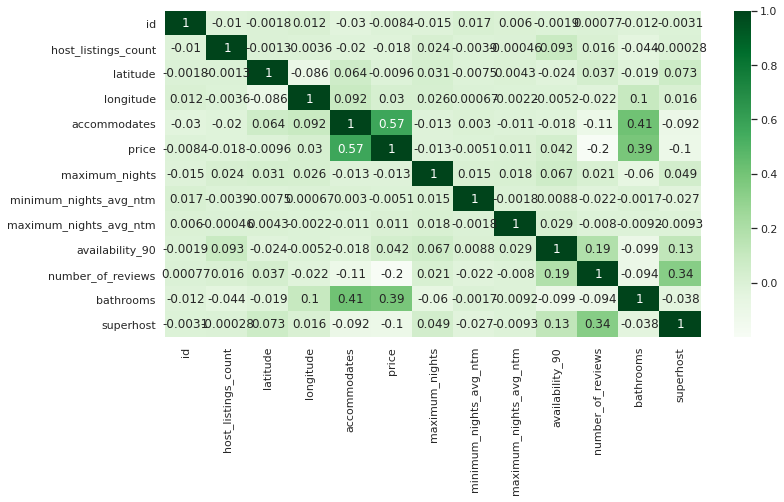

In [15]:
#as we can see in the following, the correlation is as follows:
sns.set_context("poster")
sns.set(rc={"figure.figsize": (12.,6.)})
sns.set_style("whitegrid")
sns.heatmap(df_numeric.corr(), cmap='Greens',annot=True);

In [60]:
#summary of defined functions
def bool_host(x):
    #convierto a los host en true or false (1,0)
    superhost = 0
    if x == 't':
        superhost=1
    else:
        superhost=0
    return superhost

def limpiar(df):
    df2 = df._get_numeric_data().drop(columns=['host_id', 'bathrooms', 'calendar_updated',
                                       'review_scores_rating', 'review_scores_cleanliness', 
                                       'review_scores_checkin', 'review_scores_location', 
                                       'calculated_host_listings_count', 
                                       'calculated_host_listings_count_entire_homes', 
                                       'calculated_host_listings_count_private_rooms', 
                                       'calculated_host_listings_count_shared_rooms',
                                       'reviews_per_month','scrape_id', 'neighbourhood_group_cleansed'])
    df2 = df2.drop(axis=0, index=None, columns =['bedrooms','beds',
                                        'review_scores_accuracy', 'review_scores_communication', 
                                        'review_scores_value','minimum_minimum_nights','maximum_minimum_nights', 
                                              'minimum_maximum_nights', 'maximum_maximum_nights','number_of_reviews_ltm',
                                               'number_of_reviews_l30d', 'availability_60', 
                                               'availability_30', 'availability_365',
                                               'host_total_listings_count','minimum_nights'])
    baths = list(df.bathrooms_text)
    bath = []
    half = 'half-bath'
    for i in baths:
        try:
            bath.append(float(i.split(' ', 1)[0]))
        except:
            bath.append(0.5)
    df2['bathrooms'] = bath
    df2['superhost'] = df.host_is_superhost.apply(bool_host)
    return df2
    

## THE MODEL 

After an rough consideration of multiple models, i decided to use two models to consider for the predictions:
 - XGBOOST 
 - H2O.

In [40]:
from xgboost import XGBRegressor as XGBR
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error as mse

from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import precision_score as prec
from sklearn.metrics import recall_score as rec
from sklearn.metrics import f1_score as f1
from sklearn.metrics import confusion_matrix as cm

In [20]:
#Divide the train file. At the begining with 0.8-0.2, if rmse and score are showing results, 
#i trained it with 0.5-0.5 to see the result, and after i am happy with 0.99-0.01, to feet the model with the whole set of data. 
X=df_numeric.drop('price', axis=1)
y=df_numeric.price
X_train, X_test, y_train, y_test = tts(X, y, train_size=0.8, test_size=0.2, random_state=46)

NameError: name 'tts' is not defined

In [43]:
def regre(modelo):
    
    modelo.fit(X_train, y_train)
    
    train_score=modelo.score(X_train, y_train)  # R2
    test_score=modelo.score(X_test, y_test)
    
    print(modelo)
    print('Train R2:', train_score)
    print('Test R2:', test_score)
    
    return modelo

In [44]:
xgbr_lin = XGBR(booster='gblinear',n_jobs=10, subsample_cols = 0.8, 
                            min_child_weight = 1, depth = 5, min_leaf = 5, 
                            learning_rate = 0.5, boosting_rounds = 10, lambda_ = 2, gamma = 1, eps = 0.1, verbosity=None)
xgbr_lin = regre(xgbr_lin)

y_pred = xgbr_lin.predict(X_test)
mse(y_pred, y_test, squared=False)

[16:42:46] WARNING: ../src/learner.cc:576: 
Parameters: { "boosting_rounds", "depth", "eps", "gamma", "lambda_", "min_child_weight", "min_leaf", "subsample_cols" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


XGBRegressor(base_score=0.5, booster='gblinear', boosting_rounds=10,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, depth=5, enable_categorical=False, eps=0.1,
             gamma=1, gpu_id=-1, importance_type=None,
             interaction_constraints=None, lambda_=2, learning_rate=0.5,
             max_delta_step=None, max_depth=None, min_child_weight=1,
             min_leaf=5, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=10, num_parallel_tree=None,
          

78.97627779527278

Seeing the low Rscore, with low overfitting but with a high error. H20 model will be studied.  (This model in public score of Kaggle was around 103)

Traemos el file con el test y lo limpiamos según la limpieza al train model. 

In [62]:
new_data=pd.read_csv('test.csv')

data = limpiar(new_data)

In [57]:
X.columns

Index(['id', 'host_listings_count', 'latitude', 'longitude', 'accommodates',
       'maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
       'availability_90', 'number_of_reviews', 'bathrooms', 'superhost'],
      dtype='object')

## Model H20

In [19]:
import h2o
from h2o.automl import H2OAutoML

In [20]:

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 48 mins
H2O_cluster_timezone:,Europe/Madrid
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.3
H2O_cluster_version_age:,"7 days, 22 hours and 4 minutes"
H2O_cluster_name:,H2O_from_python_lapalmi87_xfsz1y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.737 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [21]:
train=h2o.H2OFrame(df_numeric)


X=train.columns
y='price'
X.remove(y)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


H2O is a automatic model, therefore, there´s only need to define the maximum amount of models and the seed number which will give you more and better results.  In my case the seed 1 and 20 models. 

In [31]:
aml=H2OAutoML(max_models=20, seed=1)
aml.train(x=X, y=y, training_frame=train)

AutoML progress: |█Failed polling AutoML progress log: Unexpected HTTP error: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
██████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_1_AutoML_7_20220224_161343

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 2872.767828136863
RMSE: 53.59820732204449
MAE: 35.71462695663863
RMSLE: 0.27057111808864903
R^2: 0.7203015840202429
Mean Residual Deviance: 2872.767828136863
Null degrees of freedom: 3992
Residual degrees of freedom: 3985
Null deviance: 41011894.53493601
Residual deviance: 11470961.937750494
AIC: 43146.02688372964

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 5445.269123188692
RMSE: 73.79206680388273
MAE: 49.22665884757356
RMSLE: 0.3634263030191018
R^2: 0.46983771

The RMSE is also high with H20, the results were around 60 to 80. but the R2 was a bit higher in the test than with XGBOOST.

In [32]:
lb=aml.leaderboard
lb.head(rows=lb.nrows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_1_AutoML_7_20220224_161343,5445.27,73.7921,5445.27,49.2267,0.363426
StackedEnsemble_BestOfFamily_2_AutoML_7_20220224_161343,5479.08,74.0208,5479.08,49.3763,0.364337
GBM_3_AutoML_7_20220224_161343,5500.92,74.1682,5500.92,49.5219,0.366376
GBM_2_AutoML_7_20220224_161343,5504.72,74.1938,5504.72,49.6525,0.367293
XGBoost_grid_1_AutoML_7_20220224_161343_model_1,5506.91,74.2086,5506.91,49.7442,0.379607
GBM_4_AutoML_7_20220224_161343,5582.33,74.715,5582.33,49.8841,0.368795
XGBoost_grid_1_AutoML_7_20220224_161343_model_3,5606.62,74.8774,5606.62,50.1306,nan
GBM_5_AutoML_7_20220224_161343,5628.82,75.0254,5628.82,50.0775,0.370714
XRT_1_AutoML_7_20220224_161343,5644.07,75.1271,5644.07,50.3915,0.373445
StackedEnsemble_BestOfFamily_1_AutoML_7_20220224_161343,5681.53,75.3759,5681.53,50.4682,0.373811


In [33]:
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_1_AutoML_7_20220224_161343

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 2872.767828136863
RMSE: 53.59820732204449
MAE: 35.71462695663863
RMSLE: 0.27057111808864903
R^2: 0.7203015840202429
Mean Residual Deviance: 2872.767828136863
Null degrees of freedom: 3992
Residual degrees of freedom: 3985
Null deviance: 41011894.53493601
Residual deviance: 11470961.937750494
AIC: 43146.02688372964

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 5445.269123188692
RMSE: 73.79206680388273
MAE: 49.22665884757356
RMSLE: 0.3634263030191018
R^2: 0.4698377176804007
Mean Residual Deviance: 5445.269123188692
Null degrees of freedom: 3992
Residual degrees of freedom: 3985
Null deviance: 41039073.25377877
Residual deviance: 21742959.60889245
AIC: 45699.43544852113


In [34]:
new_data=pd.read_csv('test.csv')

data = limpiar(new_data)

In [35]:
data.head()

,id,host_listings_count,latitude,longitude,accommodates,maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_90,number_of_reviews,bathrooms,superhost
0,0,1,52.35713,4.92470,1,1125,2.0,1125.0,89,2,1.0,0
1,1,0,52.38810,4.91438,2,365,1.0,999.0,5,0,1.0,0
2,2,1,52.37370,4.86340,2,1125,5.0,1125.0,0,10,1.0,0
3,3,2,52.36181,4.88783,2,1125,3.0,1125.0,0,41,1.0,0
4,4,0,52.34766,4.85982,2,5,2.0,5.0,0,0,1.5,0


The cleaned data is predicted with the leader model from H2O. 

In [21]:
test=h2o.H2OFrame(data)

y_pred_h2o=aml.leader.predict(test)

data_as_df = h2o.as_list(y_pred_h2o)

NameError: name 'h2o' is not defined

In [37]:
data_as_df

,predict
0,152.546576
1,96.674723
2,111.631813
3,147.330343
4,140.522711
...,...
1384,115.746201
1385,126.717173
1386,201.080253
1387,121.358009


The prediction is used to create a file, with the right format. 

In [38]:
h2o_df=pd.DataFrame()


h2o_df['id']=[str(i) for i in range(len(y_pred_h2o))]
h2o_df['price']=data_as_df

h2o_df.shape

(1389, 2)

In [39]:
h2o_df.to_csv('h2o_pd_numeric_2.csv', index=False, header=True)